Análisis definitivo del clustering. Implementación de las funciones a utilizar, cálculo de la fire season (usando el convenio de escoger los meses que suponen el 80% del área anual quemada) y ejemplos de su utilización con la zona del Mediterráneo, una parte del Sahel y un ecosistema de la taiga.

En lugar de lanzar un clustering global, ahora se trabaja con zonas más pequeñas para obtener resultados más precisos. Se emplean los datos en escala logarítmica. Utilizamos de nuevo gaussian mixtures y consideramos como métricas el BIC y el icl, que penaliza el número de clusters.

In [1]:
# Cargamos los datos
load("ba_data.Rdata", verbose = TRUE)

Loading objects:
  df
  coords


In [2]:
# Localizamos los NAs
naind <- which(is.na(df), arr.ind = TRUE)
length(naind)

[1] 19554696

In [3]:
df.log = log1p(df)
summary(df.log)

 Jan_burned_area  Feb_burned_area  Mar_burned_area  Apr_burned_area 
 Min.   : 0.0     Min.   : 0.0     Min.   : 0.0     Min.   :0.0     
 1st Qu.: 0.0     1st Qu.: 0.0     1st Qu.: 0.0     1st Qu.:0.0     
 Median : 0.0     Median : 0.0     Median : 0.0     Median :0.0     
 Mean   : 0.7     Mean   : 0.6     Mean   : 0.8     Mean   :0.9     
 3rd Qu.: 0.0     3rd Qu.: 0.0     3rd Qu.: 0.0     3rd Qu.:0.0     
 Max.   :10.9     Max.   :10.5     Max.   :10.6     Max.   :9.9     
 NA's   :814779   NA's   :814779   NA's   :814779   NA's   :814779  
 May_burned_area  Jun_burned_area  Jul_burned_area  Aug_burned_area 
 Min.   : 0.0     Min.   : 0.0     Min.   : 0.0     Min.   : 0.0    
 1st Qu.: 0.0     1st Qu.: 0.0     1st Qu.: 0.0     1st Qu.: 0.0    
 Median : 0.0     Median : 0.0     Median : 0.0     Median : 0.0    
 Mean   : 0.9     Mean   : 0.9     Mean   : 1.2     Mean   : 1.4    
 3rd Qu.: 0.0     3rd Qu.: 0.0     3rd Qu.: 1.6     3rd Qu.: 2.2    
 Max.   :10.4     Max.   :10.7    

In [4]:
# Algunas librerías a usar
library("mclust")
require(sp)
require(magrittr)
library(dplyr)
# Para los colores
require(RColorBrewer)
group.colors <- colorRampPalette(c(brewer.pal(8, "Dark2"), brewer.pal(8, "Accent")))

Warning message:
"package 'mclust' was built under R version 3.6.3"Package 'mclust' version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.6.3"Loading required package: magrittr
Warning message:
"package 'magrittr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: RColorBrewer


Funciones a utilizar:

In [14]:
#' @title Best GMM model selection
#' @description Retain the highest BIC model after an arbitary number of GMM initializations
#' @param data Data frame
#' @param K maximun number of groups
#' @param n.inits Number of initializations. Default to 3
#' @return A mclust-class model
#' @importFrom mclust Mclust

selectBestGMM <- function(data, K, n.inits = 3) {
    i <- 1
    gmm.list <- rep(list(bquote(), n.inits))
    while (i <= n.inits) {
        set.seed(i)
        gmm.list[[i]] <- Mclust(data, G = 1:K)  
        i <- i + 1
    } 
    bics <- numeric(length(gmm.list))
    for (i in 1:length(gmm.list)) {
        bics[i] <- gmm.list[[i]]$bic
    }
    ind = which.max(bics)
    gmm <- gmm.list[[ind]]
    message("Lowest BIC: ", round(max(bics), 2))
    message("Number of clusters:", gmm$G)
    for (i in 1:n.inits){
        cat(gmm.list[[i]]$G, gmm.list[[i]]$bic, gmm.list[[i]]$icl, '\n')
    }
    return (list("gmm" = gmm.list, "ind" = ind))
}

In [6]:
#' @title Clusters' spatial location plot 
#' @description Plots the clusters' spatial location in a map
#' @param df Data frame containing the burned area data
#' @param coords Data frame containing the spatial coordinates
#' @param clus A mclust-class model
#' @param naind Vector containing the indexes where there are NAs values in df
#' @return Data of the plot

plotClust.gmm <- function(df, coords, clus, naind, ...) {
    arg.list <- list(col.regions = group.colors(clus$G),
                      at = seq(0, clus$G, 1), main = paste(toString(clus$G),"clusters"))
    # arg.list <- list()
    v <- numeric(nrow(df))
    v[naind] <- NA
    v[-naind] <- clus$classification
    df1 <- cbind.data.frame(coords, v)
    coordinates(df1) <- c(1,2)
    gridded(df1) <- TRUE
    arg.list[["obj"]] <- df1
    arg.list[["zcol"]] <- 1
    do.call("spplot", arg.list) %>% print()
    return(df1@data)
}

In [7]:
#' @title Clusters' centroids plot 
#' @description Plots the clusters' centroids and the 25 and 75 percentiles
#' @param df Data frame containing the burned area data without NAs
#' @param clus A mclust-class model
#' @param par A two-dimentional vector containing the dimensions of the grid

plotCentroids.gmm <- function(df, clus, par) {

    par(mfrow = par)

    for (i in 1:clus$G){
        centroide = colMeans(df[which(clus$classification == i),])

        per.25 = c()
        per.75 = c()
        for (j in 1:12){
            per.25[j] = quantile(df[which(clus$classification == i),j], prob=0.25)
            per.75[j] = quantile(df[which(clus$classification == i),j], prob=0.75)
        }

        plot(per.75, col = 'blue', type = 'l', xlab = "Mes", ylab = "Burned Area",
            main = paste('Cluster', toString(i)), sub = paste('Tamaño', toString(sum(clus$classification == i))))
        lines(1:12, centroide, col = "red")
        lines(1:12, per.25, col = "green")        
    }
}

In [8]:
#' @title Fire season calculation 
#' @description Calculates the fire season of each of the clusters of the mclust model
#' @param df Data frame containing the no Nas burned area data
#' @param clus A mclust-class model
#' @return List containing the fire season of each of the clusters

fireSeason = function(df, clus){
    fire.season = list()
    for (i in 1:clus$G){
        centroide = colMeans(df[which(clus$classification == i),])
        anual = as.data.frame(centroide)
        anual$mes = 1:12
        anual = arrange(anual, -centroide)
        total = sum(anual$centroide)
        suma = 0
        mes = 1
        f.season = c()
        while (suma < 0.8 * total){
            suma = suma + anual$centroide[mes]
            mes = mes + 1
        }
        f.season = sort(anual[1:(mes-1),]$mes)
        #f.season = c(f.season, substr(attr(centroide, "names")[j], start = 1, stop = 3))
        cat(f.season, "\n")
        fire.season[[i]] = f.season
    }
    return (fire.season)
}

## Análisis de la zona mediterránea

In [12]:
# coordenadas mediterraneas: 
lon <- c(-10, 20)
lat <- c(35, 46)

In [116]:
ind.coords.med = which(coords$x < 30 & coords$x > -10 & coords$y > 35 & coords$y < 47)
df.log.med = df.log[ind.coords.med,]
df.med = df[ind.coords.med,]
coords.med = coords[ind.coords.med,]

In [117]:
# Localizamos los NAs
naind.med <- which(is.na(df.log.med), arr.ind = TRUE)
length(naind.med)

[1] 76176

In [45]:
# Lanzamos el clustering
gmmMed <- selectBestGMM(data = df.log.med[-naind.med, ], K = 15, n.inits = 15)

Lowest BIC: NA
Number of clusters:7


6 -103166.4 -104905.3 
4 -111436.3 -111985.7 
7 -96421.29 -96717.99 
7 NA NA 
4 NA NA 
6 NA NA 
5 -109816.5 -110398.1 
4 -111011.3 -111140.4 
5 -108452.4 -108988.5 
4 -110978.8 -111108.2 
4 -112810.5 -113329.2 
4 -112244 -113521.3 
7 NA NA 
6 -106190.9 -108725.4 
11 NA NA 


Algunos intentos del clustering no han registrado el valor del BIC y hay que analizarlos uno a uno para verlo.

In [51]:
gmmMed$gmm[[4]]$BIC

Bayesian Information Criterion (BIC): 
         EII       VII       EEI       VEI       EVI       VVI       EEE
1  -197940.4 -197940.4 -169704.6 -169704.6 -169704.6 -169704.6 -143848.5
2  -170261.3        NA -155745.1        NA        NA        NA -142089.4
3  -162405.3        NA -150622.8        NA        NA        NA -140307.8
4  -159407.1        NA -143534.3        NA        NA        NA -135336.7
5  -155841.3        NA -140520.4        NA        NA        NA -134496.1
6  -154196.8        NA -138021.3        NA        NA        NA -129797.2
7  -151100.4        NA -137379.5        NA        NA        NA -130227.9
8  -149482.1        NA -137488.3        NA        NA        NA -127997.4
9  -146346.7        NA -136448.5        NA        NA        NA -128106.7
10 -145196.8        NA -136557.9        NA        NA        NA -127528.1
11 -143708.7        NA -136278.0        NA        NA        NA -127329.8
12 -142127.1        NA -136314.8        NA        NA        NA -127141.7
13 -141701.6

In [52]:
gmmMed$gmm[[5]]$BIC

Bayesian Information Criterion (BIC): 
         EII       VII       EEI       VEI       EVI       VVI       EEE
1  -197940.4 -197940.4 -169704.6 -169704.6 -169704.6 -169704.6 -143848.5
2  -170261.3        NA -155745.0        NA        NA        NA -142089.5
3  -162405.2        NA -150622.6        NA        NA        NA -140307.0
4  -159405.6        NA -143534.2        NA        NA        NA -135336.0
5  -155840.5        NA -140520.5        NA        NA        NA -134496.6
6  -154197.4        NA -138021.0        NA        NA        NA -129794.4
7  -151100.6        NA -138130.0        NA        NA        NA -129429.5
8  -148431.9        NA -137488.7        NA        NA        NA -128063.5
9  -148582.3        NA -136448.7        NA        NA        NA -127396.2
10 -145502.1        NA -136169.5        NA        NA        NA -127207.1
11 -143911.5        NA -134651.7        NA        NA        NA -126901.1
12 -142125.9        NA -134760.4        NA        NA        NA -126684.1
13 -142236.5

In [53]:
gmmMed$gmm[[6]]$BIC

Bayesian Information Criterion (BIC): 
         EII       VII       EEI       VEI       EVI       VVI       EEE
1  -197940.4 -197940.4 -169704.6 -169704.6 -169704.6 -169704.6 -143848.5
2  -170261.3        NA -155745.1        NA        NA        NA -142089.4
3  -162404.9        NA -150622.2        NA        NA        NA -140081.2
4  -159405.4        NA -143534.2        NA        NA        NA -131422.7
5  -156037.7        NA -140520.5        NA        NA        NA -130950.7
6  -152960.7        NA -138020.2        NA        NA        NA -130437.8
7  -151100.8        NA -137379.6        NA        NA        NA -128156.4
8  -149384.8        NA -137488.5        NA        NA        NA -128064.1
9  -147746.7        NA -135639.3        NA        NA        NA -127773.9
10 -145189.5        NA -134774.5        NA        NA        NA -127129.4
11 -145298.8        NA -134884.1        NA        NA        NA -127238.5
12 -144216.3        NA -134680.6        NA        NA        NA -126923.3
13 -142584.9

In [54]:
gmmMed$gmm[[13]]$BIC

Bayesian Information Criterion (BIC): 
         EII       VII       EEI       VEI       EVI       VVI       EEE
1  -197940.4 -197940.4 -169704.6 -169704.6 -169704.6 -169704.6 -143848.5
2  -170261.3        NA -155745.1        NA        NA        NA -142089.5
3  -162405.1        NA -150622.7        NA        NA        NA -139728.2
4  -159207.1        NA -144912.5        NA        NA        NA -136745.4
5  -155842.7        NA -140520.4        NA        NA        NA -130954.3
6  -154192.7        NA -140853.0        NA        NA        NA -128514.8
7  -151100.9        NA -138130.9        NA        NA        NA -127945.3
8  -149253.6        NA -137488.3        NA        NA        NA -128020.4
9  -146496.4        NA -136448.5        NA        NA        NA -128173.6
10 -145196.5        NA -137189.4        NA        NA        NA -127883.8
11 -144107.1        NA -134885.6        NA        NA        NA -128940.9
12 -142475.7        NA -134642.8        NA        NA        NA -127138.8
13 -142584.8

In [55]:
gmmMed$gmm[[15]]$BIC

Bayesian Information Criterion (BIC): 
         EII       VII       EEI       VEI       EVI       VVI       EEE
1  -197940.4 -197940.4 -169704.6 -169704.6 -169704.6 -169704.6 -143848.5
2  -170261.3        NA -155745.0        NA        NA        NA -142089.5
3  -162404.8        NA -150622.3        NA        NA        NA -138562.7
4  -159407.4        NA -143533.7        NA        NA        NA -137876.4
5  -155841.9        NA -140743.8        NA        NA        NA -133216.8
6  -154198.1        NA -138020.9        NA        NA        NA -132268.8
7  -151222.1        NA -141743.7        NA        NA        NA -132195.0
8  -149483.7        NA -138185.1        NA        NA        NA -131819.0
9  -146499.3        NA -137077.6        NA        NA        NA -131928.6
10 -145196.8        NA -136627.3        NA        NA        NA -131756.7
11 -143590.2        NA -136645.6        NA        NA        NA -131301.6
12 -144217.1        NA -133991.3        NA        NA        NA -127121.8
13 -143445.0

El mejor modelo es el tercero, que tiene 7 clusters. Vemos que a diferencia de cuando hacíamos el clustering global ahora el método no nos pide cada vez más grupos. Vamos a analizar este modelo más en profundidad.

In [120]:
# Tamaño de los clusters
for (i in 1:7){
    cat(i, sum(gmmMed$gmm[[3]]$classification == i),'\n')
}

1 510 
2 155 
3 104 
4 91 
5 3196 
6 187 
7 263 


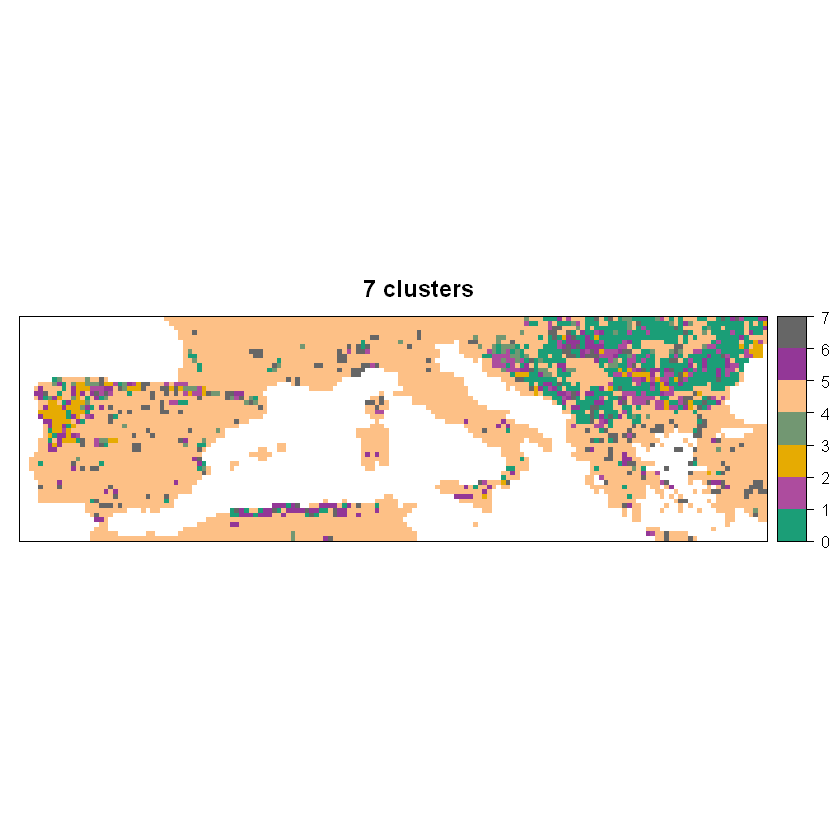

In [61]:
# Representación espacial de los clusters
gmm.log <- plotClust.gmm(df.log.med, coords.med, gmmMed$gmm[[3]], naind.med)

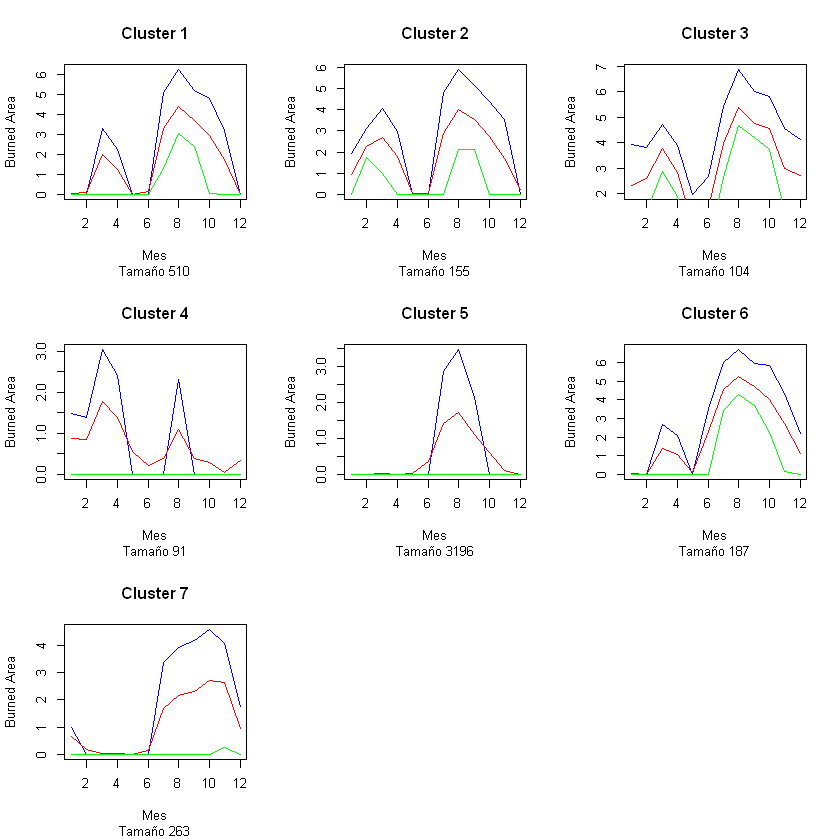

In [129]:
# Centroides (en rojo) y percentiles 25 y 75 de cada cluster
plotCentroids.gmm(df.log.med[-naind.med, ], gmmMed$gmm[[3]], c(3,3))

In [123]:
# Fire season obtenidas
fireSeason.med = fireSeason(df.log.med[-naind.med, ], gmmMed$gmm[[3]])

3 7 8 9 10 
2 3 4 7 8 9 10 
3 4 7 8 9 10 11 12 
1 2 3 4 5 7 8 
7 8 9 10 
6 7 8 9 10 11 
7 8 9 10 11 


Obtenemos 7 clusters con un tamaño y una coherencia espacial suficientes, con la excepción del cluster 4. De las fire season hay 4 bimodales y 3 unimodales, aunque los grupos 4 y 5 tienen poca superficie quemada. No hay fire season repetidas.

## Análisis de la taiga siberiana

In [7]:
# coordenadas: 
lon.t <- c(65, 85)
lat.t <- c(55, 65)

In [8]:
ind.coords.t = which(coords$x < lon.t[2] & coords$x > lon.t[1] & coords$y > lat.t[1] & coords$y < lat.t[2])
df.log.t = df.log[ind.coords.t,]
df.t = df[ind.coords.t,]
coords.t = coords[ind.coords.t,]

In [9]:
# Localizamos los NAs
naind.t <- which(is.na(df.log.t), arr.ind = TRUE)
length(naind.t)

[1] 0

In [36]:
# Realizamos el clustering
gmm.t <- selectBestGMM(data = df.log.t, K = 9, n.inits = 15)

Lowest BIC: -91391.97
Number of clusters:9


9 -91831.44 -92130.16 
9 -91830.84 -92126.52 
9 -91831.32 -92129.43 
9 -91830.98 -92129.88 
9 -91830.75 -92128.36 
9 -93404.12 -93702.02 
9 -91830.72 -92127.38 
9 -91830.74 -92127.47 
9 -91391.97 -91632.87 
9 -93416.24 -93709.25 
9 -91831.13 -92130.83 
9 -91830.76 -92128.35 
9 -91831.34 -92131.15 
9 -93375.1 -93689.38 
9 -91831.01 -92128.31 


En este caso casi todos los intentos son muy parecidos, nos quedaremos con el 9 que es el mejor en cuanto a BIC e icl. Se ha establecido el límite de 9 clusters como máximo porque por encima de ese número obteníamos grupos incoherentes.

In [37]:
# Tamaño de los clusters
for (i in 1:9){
    cat(i, sum(gmm.t$gmm[[9]]$classification == i),'\n')
}

1 1214 
2 118 
3 264 
4 196 
5 205 
6 195 
7 247 
8 479 
9 282 


Warning message in v[-naind] <- clus$classification:
"número de items para para sustituir no es un múltiplo de la longitud del reemplazo"

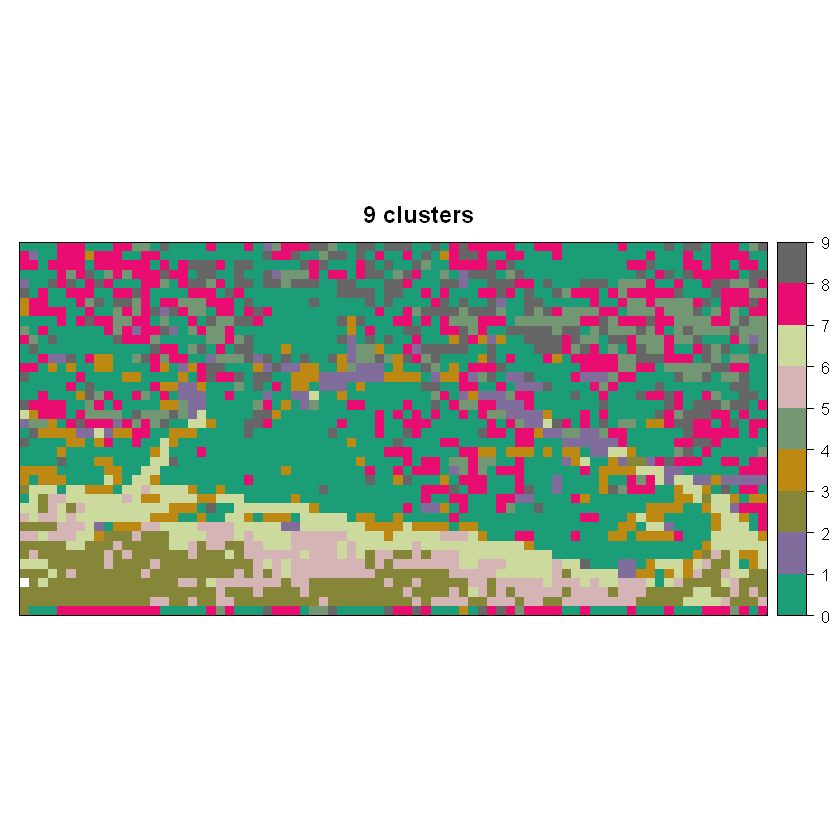

In [38]:
gmm.log <- plotClust.gmm(df.log.t, coords.t, gmm.t$gmm[[9]], 4)

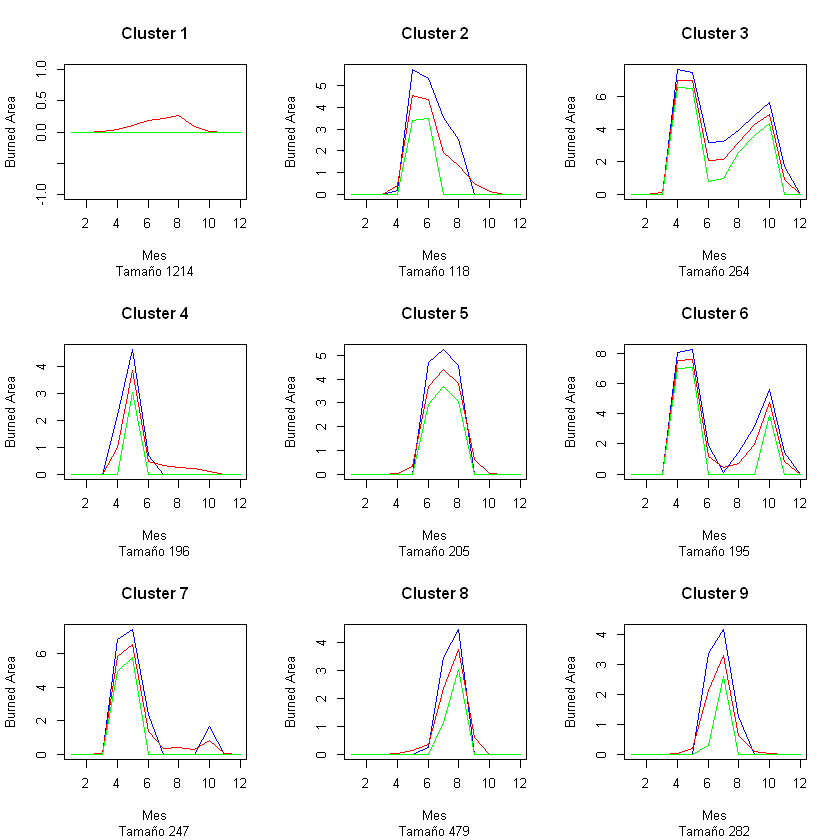

In [130]:
plotCentroids.gmm(df.log.t, gmm.t$gmm[[9]], c(3,3))

In [112]:
fireSeason.t = fireSeason(df.log.t, gmm.t$gmm[[9]])

5 6 7 8 
5 6 7 
4 5 8 9 10 
4 5 6 
6 7 8 
4 5 9 10 
4 5 6 
7 8 
6 7 


Aún con 9 clusters, los grupos 4 y 9 no tienen mucha coherencia espacial. De las fire season obtenidas, hay dos bimodales, una casi plana y el resto unimodales. Dos de ellas se solapan.

## Análisis del Sahel

In [22]:
# coordenadas: 
lon.s <- c(7.5, 25)
lat.s <- c(-2, 5)

ind.coords.s = which(coords$x < lon.s[2] & coords$x > lon.s[1] & coords$y > lat.s[1] & coords$y < lat.s[2])
df.log.s = df.log[ind.coords.s,]
df.s = df[ind.coords.s,]
coords.s = coords[ind.coords.s,]

In [23]:
# Localizamos los NAs
naind.s <- which(is.na(df.log.s), arr.ind = TRUE)
length(naind.s)

[1] 4416

In [33]:
# Realizamos el clustering
gmm.s <- selectBestGMM(data = df.log.s[-naind.s, ], K = 9, n.inits = 3)

Lowest BIC: -38884.17
Number of clusters:7


7 -38884.17 -39407.07 
7 -38884.17 -39407.07 
7 -38884.17 -39407.07 


Los resultados son idénticos, no tenía sentido hacer más intentos. Se ha puesto límite 9 porque en caso contrario obteníamos 11 clusters con 2 de ellos (el 3 y el 5) claramente prescindibles, como se ve en la figura:

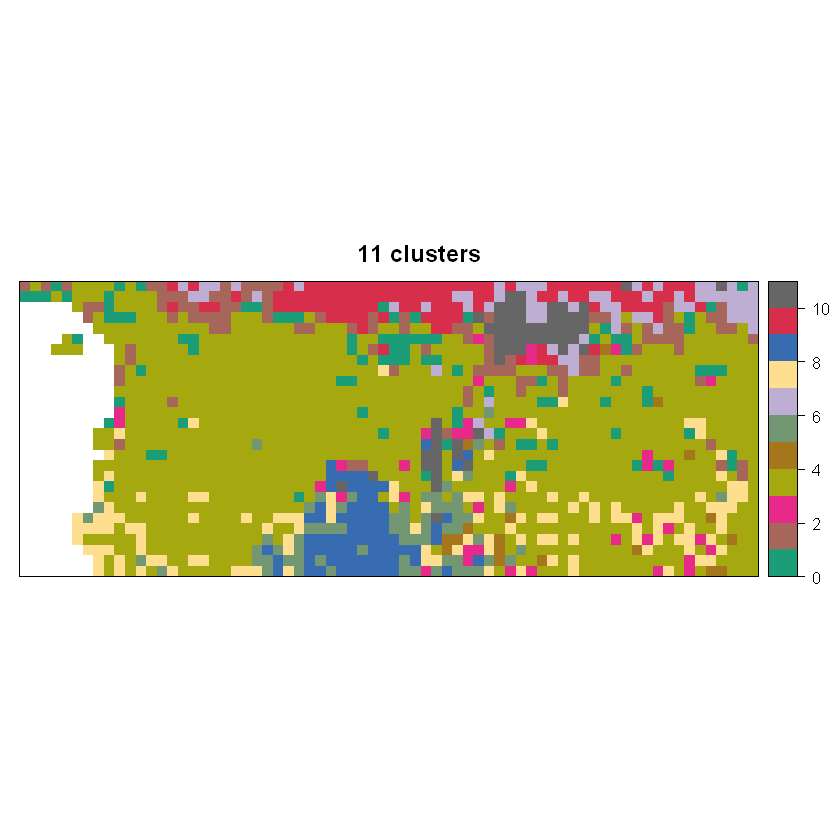

In [45]:
gmm.log <- plotClust.gmm(df.log.s, coords.s, gmm.s$gmm[[1]], naind.s)

In [34]:
# Tamaño de los clusters
for (i in 1:7){
    cat(i, sum(gmm.s$gmm[[1]]$classification == i),'\n')
}

1 187 
2 140 
3 1064 
4 148 
5 93 
6 82 
7 62 


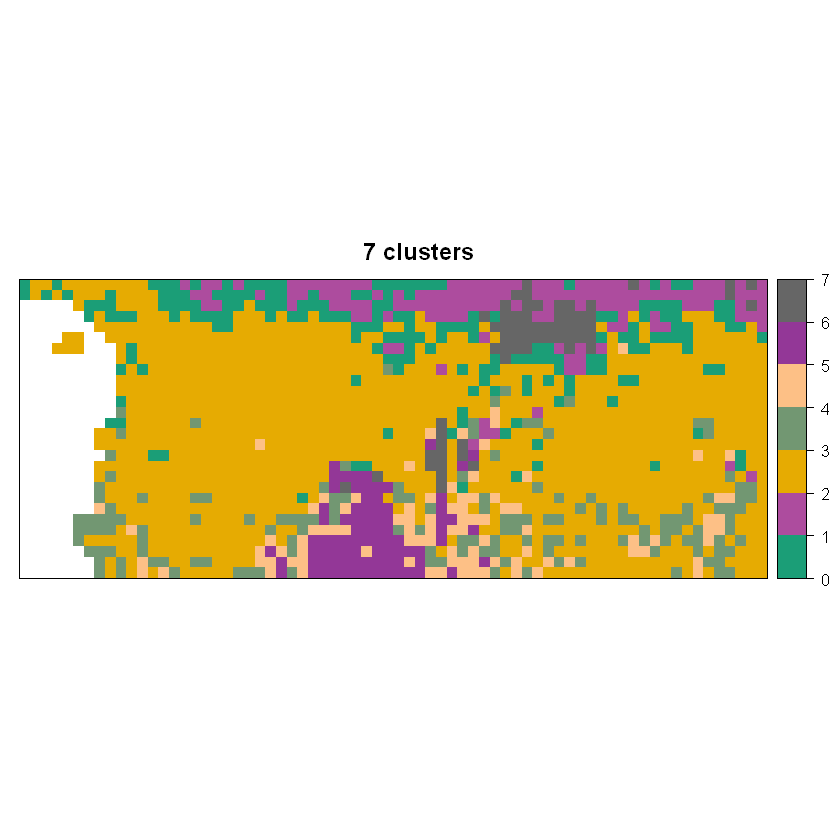

In [36]:
gmm.log <- plotClust.gmm(df.log.s, coords.s, gmm.s$gmm[[1]], naind.s)

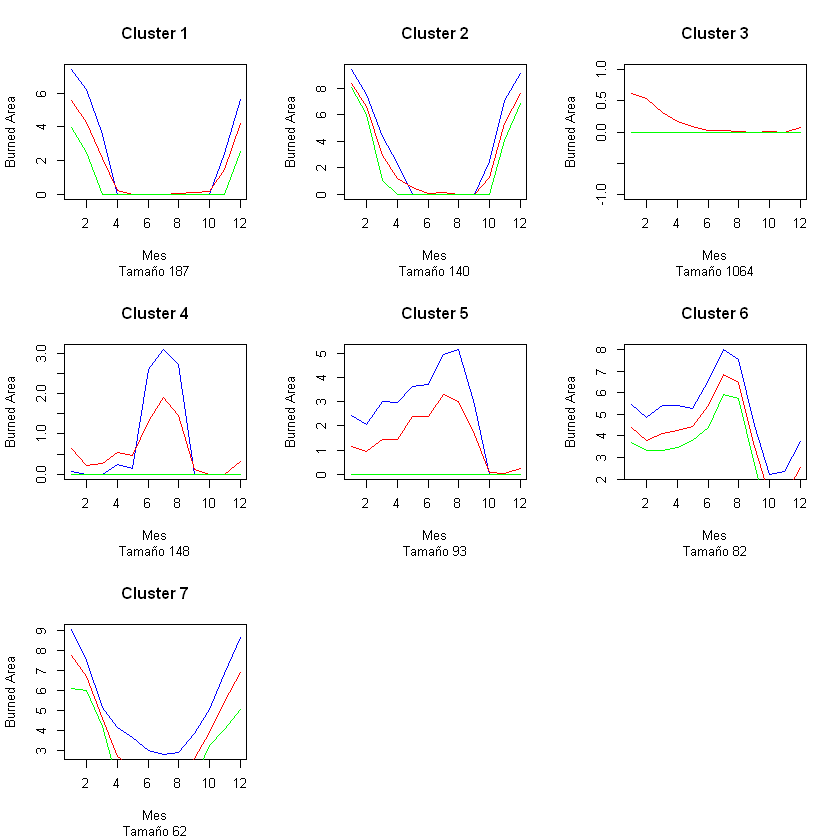

In [38]:
plotCentroids.gmm(df.log.s[-naind.s, ],gmm.s$gmm[[1]], c(3,3))

In [37]:
fireSeason.s = fireSeason(df.log.s[-naind.s, ],gmm.s$gmm[[1]])

1 2 3 12 
1 2 11 12 
1 2 3 4 
1 4 6 7 8 
3 4 5 6 7 8 9 
1 2 3 4 5 6 7 8 
1 2 3 4 9 10 11 12 


Salen 7 grupos, uno de ellos tiene una fire season plana, no hay bimodales y el cluster 4 tiene una fire season degenerada.